In [1]:
import numpy as np
import scipy.linalg as la
import xarray as xr
import matplotlib.pyplot as plt
from itertools import product

In [2]:
ds_d=xr.open_dataset('/home/rfajber/ResearchMethodsCourse/data/NAbox.doer3.precip.mon.mean.nc').sel(time=slice('1980-01-01','2014-12-01'))
precipD = ds_d.prate.data*1000/999.7*(24*3600) # convert from kg/m^2/s to mm/day
lon,lat = ds_d.longitude.data, ds_d.latitude.data
nlon,nlat = len(lon),len(lat)
precipD = np.reshape(precipD,[35,12,nlon*nlat])

precipDAnom = precipD - precipD.mean(axis=0) 

In [3]:
ds_g=xr.open_dataset('/home/rfajber/ResearchMethodsCourse/data/NAboxgpcp.precip.mon.nc',
                          decode_times='False').sel(time=slice('1980-01-01','2014-12-31'))
precipG=ds_g.precip.data#/1000*999.7/(24*3600) # convert from mm/day to kg/m^2/s
precipG = np.reshape(precipG,[35,12,nlon*nlat])

precipGAnom = precipG - precipG.mean(axis=0)

In [4]:
# setting up the ingredients for OI

lon2,lat2=np.meshgrid(lon,lat)

def createSpatialFilter(r0=5):
    spatialFilter=np.zeros([nlat,nlon,nlat,nlon])
    for i,j in product(range(0,nlat),range(0,nlon)):
        spatialFilter[i,j]=np.exp( -0.5*((lat2-lat[i])**2 +(lon2-lon[j])**2)/r0**2)

    spatialFilter=np.reshape(spatialFilter,[nlat*nlon,nlat*nlon])
    return spatialFilter
    
def doOI(xb,z,gammaB,gammaR,H):
    Si=la.inv(np.dot(np.dot(H,gammaB),H.T)+gammaR)
    K = np.dot(gammaB,np.dot(H.T,Si))
    xa = xb+ np.dot(K,z-np.dot(H,xb))
    return xa


# observation operators
H0 = np.eye(nlat*nlon)

H1 = np.eye(nlat*nlon)
H1 = H1[:nlat*nlon//2]

H2 = np.eye(nlat*nlon)
H2 = H2[nlat*nlon//2:]

# put these in a list so that we can choose them later
Hl = [H0,H1,H2]


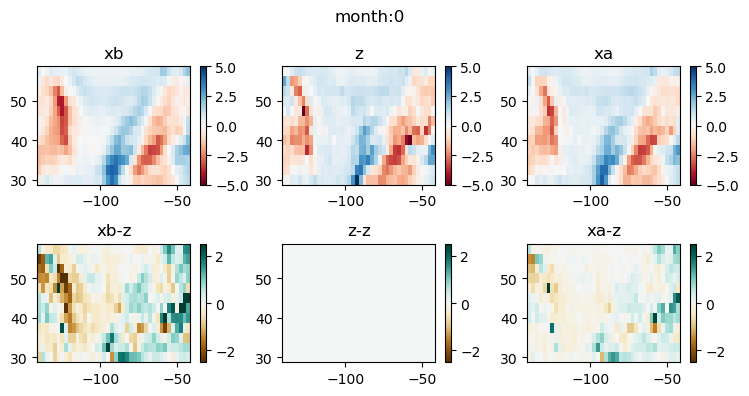

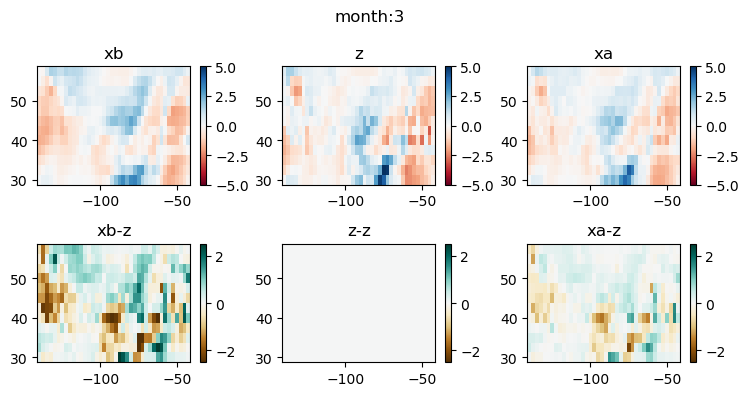

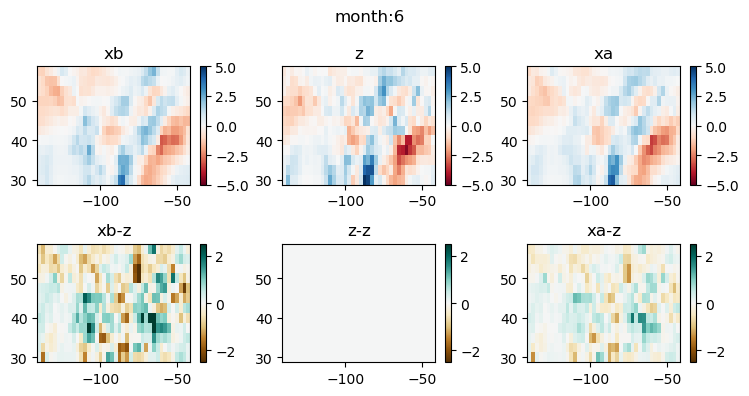

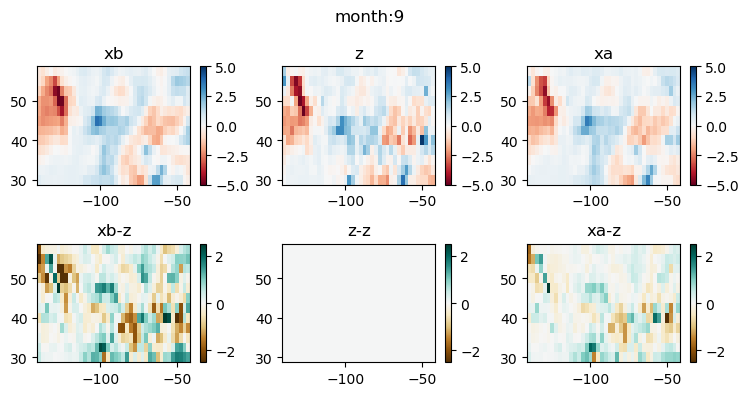

In [5]:
# parameters that control the simulations
doSpatialFilter=True
r0=1

Hoption=0
H = Hl[Hoption]

# some plotting parameters 
cmap1=plt.cm.RdBu
cmap2=plt.cm.BrBG

titles=['xb','z','xa']
titles2=['xb-z','z-z','xa-z']

for m in range(0,12,3):

    # select the data and remove means 
    xb = precipDAnom[:-1,m]
    z = precipGAnom[:-1,m]

    xb -= xb.mean(axis=-1)[:,np.newaxis]
    z -= z.mean(axis=-1)[:,np.newaxis]

    xbAnom = xb - xb.mean(axis=0)
    zAnom = z - z.mean(axis=0)

    # selection tree to apply Hoption and the spatial filtering
    if Hoption==0:
        if doSpatialFilter:
            spatialFilter=createSpatialFilter(r0=r0)
            gammaB = spatialFilter*np.dot(xbAnom.T,xbAnom)
            gammaR = spatialFilter*np.dot(zAnom.T,zAnom)
        else:
            gammaB = np.dot(xbAnom.T,xbAnom)
            gammaR = np.dot(zAnom.T,zAnom)
        xa = doOI(xb[-1],z[-1],gammaB,gammaR,H)
    elif Hoption==1:
        if doSpatialFilter:
            spatialFilter=createSpatialFilter(r0=r0)
            gammaB = spatialFilter*np.dot(xbAnom.T,xbAnom)
            gammaR = spatialFilter*np.dot(zAnom.T,zAnom)
        else:
            gammaB = np.dot(xbAnom.T,xbAnom)
            gammaR = np.dot(zAnom.T,zAnom)
        gammaR = gammaR[:nlat*nlon//2,:nlat*nlon//2]
        xa = doOI(xb[-1],z[-1,:nlon*nlat//2],gammaB,gammaR,H)
    elif Hoption==2:
        if doSpatialFilter:
            spatialFilter=createSpatialFilter(r0=r0)
            gammaB = spatialFilter*np.dot(xbAnom.T,xbAnom)
            gammaR = spatialFilter*np.dot(zAnom.T,zAnom)
        else:
            gammaB = np.dot(xbAnom.T,xbAnom)
            gammaR = np.dot(zAnom.T,zAnom)
        gammaR = gammaR[nlat*nlon//2:,nlat*nlon//2:]
        xa = doOI(precipDAnom[-1,m],precipGAnom[-1,m,nlon*nlat//2:],gammaB,gammaR,H)


    # put the data into a list so that we can loop over it 
    datal=[xb[-1],z[-1],xa]

    # make plots by looping over datal
    plt.figure(m,figsize=(7.5,4))
    plt.suptitle(f'month:{m}')
    for i in range(0,3):
        plt.subplot(2,3,i+1)
        plt.pcolormesh(lon,lat,np.reshape(datal[i],[nlat,nlon]),
                       vmin=-5,vmax=5,cmap=cmap1
        )
        plt.colorbar()
        plt.title(titles[i])


        plt.subplot(2,3,i+4)
        plt.pcolormesh(lon,lat,np.reshape(datal[i]-datal[1],[nlat,nlon]),
                       vmin=-2.5,vmax=2.5,cmap=cmap2
        )
        plt.colorbar()
        plt.title(titles2[i])
    plt.tight_layout()
